## Lecture 4.5: Simulating the Coalescent

In [150]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from scipy.special import comb

**1. Simulate a single coalescent genealogy with $n=20$ samples in a population of size $N=200$.**

<span style="color:green;">**Discussion:** When we say "simulate a genealogy" what does that mean? In other words what information do we need to create?</span>

There are two answers to this question. 
1) We need to simulate the *coalescent times*
2) We can also simulate who coalesced with whom.

If all we care about is the **Topology** of the genealogy all we need is (1).  If we are interested in mutations however we are going to need both. Note that the two are completely independent of one another so we can simulate them separately.

**1a: Simulate the coalescent times.**

Recall that the coalescent times are given by the **Kingman Coalescent Distribution**.

$$
\Pr(T_i=\tau)=\binom{i}{2}e^{-\binom{i}{2}\tau}
$$

where time $\tau$ is measured in units of $N$ generations.

In [2]:
def SimCoalTimes(n):
    Tlist=np.zeros(n-1)
    for i in range(2,n+1):
        lam=math.comb(i, 2)
        Tlist[i-2]=np.random.exponential(scale=1/lam)
    return Tlist
#Simulate the times for the focal coalescent
focalCoal=SimCoalTimes(20)

To plot the coalescent times on a time line we have to flip the array (event $n$ occurs last) and then accumulate the values as this gives the inter-coalescent intervals not the total times.

In [3]:
focalCoalTotal=np.cumsum(np.flip(focalCoal*200)) #We need to flip the order and then add the times.
print(focalCoalTotal)
print(np.flip(list(range(2, 21))))

[  1.22483865   1.29337055   1.56345445   3.6549837    4.75403785
  13.15946408  18.81794942  23.22919202  26.13687194  35.38562036
  37.03708137  51.51165105  62.14711461  63.39661099  71.50297
 102.81621748 147.24398264 151.23623717 200.63229891]
[20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2]


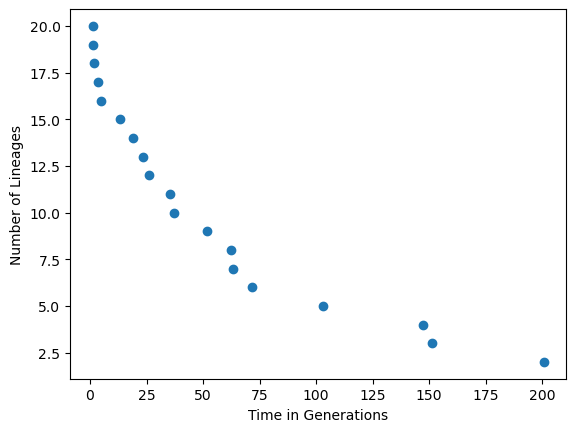

In [4]:
plt.scatter(focalCoalTotal,np.flip(list(range(2, 21))))
plt.xlabel("Time in Generations")
plt.ylabel("Number of Lineages");

**1b. Simulate the coalescent topology**

On one hand, this simulation is easy, lineages are assumed to coalesce at random, so conceptually we need to do is choose two lineages at random to coalesce at each event. The challenge is keeping track of the information.

There is no one solution to this and information about topologies of genealogies and phylogenies is stored in many different ways. One nice thing about the coalescent is that it is a **binary tree**, in that we only ever have two lineages coming together at the same time.  For here we will store the information in the form of a **cophenetic matrix** simulating the data **forward-in-time** from $T_2$ to $T_n$. 


<span style="color:purple;">**See Notes**</span>

In [79]:
def SimCoalTopology(times):
    #Initial matrix
    mtrx=np.array([[times[0],0],[0,times[0]]])
    for j in range(1,len(times)):
        # Add Lineage
        par=random.randint(0, len(mtrx)-1)
        # mtrx=np.hstack((mtrx, np.array([mtrx[:,par]])))
        mtrx = np.append(mtrx, [mtrx[par]], axis=0)
        mtrx=np.transpose(mtrx)
        mtrx = np.append(mtrx, [mtrx[par]], axis=0)
        # Increment
        mtrx=mtrx+np.identity(len(mtrx))*times[j]
    return mtrx

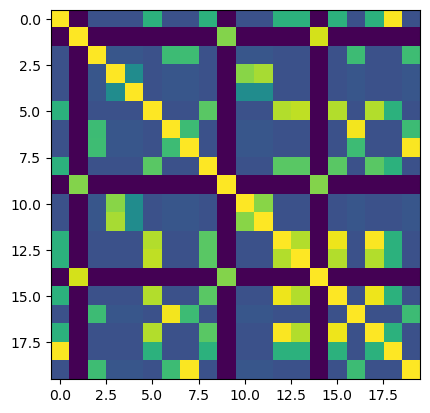

In [84]:
focalTopo=SimCoalTopology(focalCoal)
plt.imshow(focalTopo, cmap='viridis', interpolation='nearest');

**2. Given a set of coalescent times, simulate mutations under an infinite sites model and calculate the number of segregating sites and the number of pairwise differences**

The cophenetic matrix above is given in terms of time, however, we can record any measure of distance between lineages, not just time.  So to simulate an infinite sites model we just need to exchange time for mutations.  This is easy to do, by recognizing that the number of mutations $n$ that occur along an edge of length $T_i$ is:

$$
n\sim\mathcal{Poi}(\mu T_i)
$$

Where $\mu$ is the mutation rate in coalescent generations.  We can implement this by adding a simulated value $n_l$ to each lineage $l$ instead of a fixed time (note that each lineage may accumulate a different number of mutations).

To calculate the **number of segregating sites** we just have to count how many mutations occurred.

In [133]:
def SimInfiniteSites(times,mu):
    #Initial matrix
    meanN=1/(times[0]*mu)
    mtrx=np.array([[np.random.poisson(meanN),0],[0,np.random.poisson(meanN)]])
    numSeg=mtrx[0,0]+mtrx[1,1]
    for j in range(1,len(times)):
        # Add Lineage
        par=random.randint(0, len(mtrx)-1)
        # mtrx=np.hstack((mtrx, np.array([mtrx[:,par]])))
        mtrx = np.append(mtrx, [mtrx[par]], axis=0)
        mtrx=np.transpose(mtrx)
        mtrx = np.append(mtrx, [mtrx[par]], axis=0)
        # Increment
        meanN=times[j]*mu #expected number of mutations in this coalescent interval
        for k in range(len(mtrx)):
            temp=np.random.poisson(meanN)
            numSeg+=temp
            mtrx[k,k]+=temp
    return [mtrx,numSeg]

60


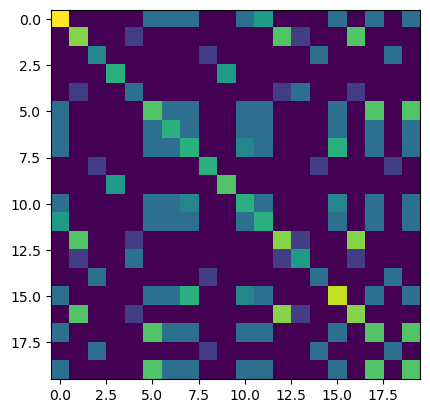

In [136]:
focalInfSites=SimInfiniteSites(focalCoal,10)
print(focalInfSites[1])
plt.imshow(focalInfSites[0], cmap='viridis', interpolation='nearest');

To calculate the **number of pairwise differences** between lineages $i$ and $j$ we just need to take the number of mutations each has accumulated minus the number they share in common.

$$
\pi_{i,j}=M_{i,i}+M_{j,j}-2*M_{i,j}
$$

In [145]:
def piMtrx(infSitesMtrx):
    mtrx=np.zeros((len(infSitesMtrx),len(infSitesMtrx)))
    for i in range(len(infSitesMtrx)):
        for j in range(i,len(infSitesMtrx)):
            mtrx[i,j]=infSitesMtrx[i,i]+infSitesMtrx[j,j]-2*infSitesMtrx[i,j]
    return mtrx

12.1


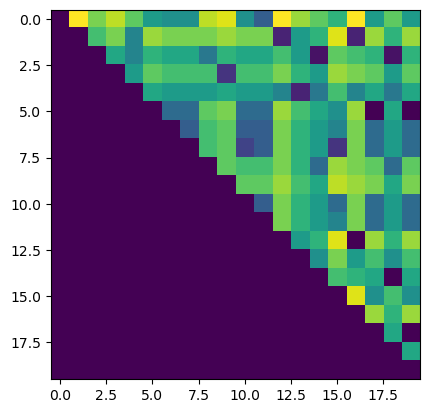

In [152]:
focalPiMtrx=piMtrx(focalInfSites[0])
## Calculating the average number of pairwise differences by dividing the total by n choose 2
focalPi=np.sum(np.triu(focalPiMtrx, k=1))/comb(len(focalPiMtrx), 2, exact=True)
plt.imshow(focalPiMtrx, cmap='viridis', interpolation='nearest');
print(focalPi)